# Import thư viện

In [287]:
import numpy as np  
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from scipy.stats import ttest_ind_from_stats
from IPython.display import clear_output 
from celluloid import Camera

# Fobj

In [288]:
# Rastrigin
def f(z):
    res = 10*len(z)
    for i in range(len(z)):
        res += (z[i]*z[i] - 10.0 * np.cos(2*np.pi*z[i]))

    return res

def F(x,y):
    res = 20.0
    res += (x*x - 10.0*np.cos(2*np.pi*x))
    res += (y*y - 10.0*np.cos(2*np.pi*y))

    return res

In [289]:
#Sphere
def Sphere(z):
    res = 0.0
    for i in range(len(z)):
        res += z[i]**2
    return res

In [290]:
#Zakharov
def Zakharov(z):
    sum1, sum2 = 0.0, 0.0
    for i in range(len(z)):
        sum1 += z[i]**2
        sum2 += 0.5*(i+1)*z[i]**2
    res = sum1**2 + sum2**2 + sum2**4
    return res

In [291]:
#Rosenbrock
def Rosenbrock(z):
    sum = 0.0
    for i in range(len(z)-1):
        new = 100*(z[i+1]-z[i]**2)**2 + (z[i]-1)**2
        sum+= new
    return sum

In [292]:
#Michalewicz
def Michalewicz(z, m=10):
    sum = 0.0
    for i in range(len(z)):
        new = np.sin(z[i])*np.sin((i+1)*z[i]**2/np.pi)**(2*m)
        sum += new
    return -sum

In [293]:
#Ackley
def Ackley(z, a=20, b=0.2, c=2*np.pi):
    d = len(z)
    sum1, sum2 = 0.0, 0.0
    for i in range(len(z)):
        sum1 += z[i]**2
        sum2 += np.cos(c*z[i])
      
    term1 = -a*np.exp(-b*np.sqrt(sum1/d))
    term2 = -np.exp(sum2/d)

    res = term1 + term2 + a + np.exp(1)
    return res


In [236]:
def Bound(f):
    if f == Sphere:
        return [(-5.12, 5.12)]
    if f == Zakharov or f == Rosenbrock:
        return [(-5, 10)]
    if f == Michalewicz:
        return [(0, np.pi)]
    if f == Ackley:
        return [(-32.768, 32.768)]

# DE

In [278]:
def de(fobj, bounds, popsize=20, mssv=20521493):
    F_scale=0.8
    cross_prob=0.7
    np.random.seed(mssv)
    dimensions = len(bounds)
    count = 0
    lower_bound, upper_bound = np.asarray(bounds).T
    diff = np.fabs(lower_bound - upper_bound)

    pop = lower_bound + diff * np.random.rand(popsize, dimensions)
    fitness = np.asarray([fobj(ind) for ind in pop])
    count += len(pop)
    best_idx = np.argmin(fitness)

    best = pop[best_idx]

    results = []
    all_pops = []
    results.append((np.copy(best), fitness[best_idx], count))
    all_pops.append(np.copy(pop))
    while True:
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F_scale * (b-c), lower_bound, upper_bound)

            cross_points = np.random.rand(dimensions) < cross_prob
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            
            trial = np.where(cross_points, mutant, pop[j])
            f = fobj(trial)
            count += 1

            if dimensions == 2 and count > 100000:
                  return results, all_pops
            elif dimensions == 10 and count > 1000000:
                  return results, all_pops
            
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial
        
        results.append((np.copy(best), fitness[best_idx], count))
        all_pops.append(np.copy(pop))
        

    return results, all_pops


## Running DE

In [238]:
# def implementation(f, name):
#     d = np.array([2, 10])
#     n = np.array([32, 64, 128, 256, 512, 1024])

#     final = [[] for _ in range(len(n))]
#     j = 0
#     for pop in n:
#       for idx in d:
#         for i in range(10):
#           mssv=20521493+i
#           results, all_pops = de(f, bounds=Bound(f)*idx, popsize=pop, mssv=mssv)
#           with open("/content/gdrive/MyDrive/CS410/DE/"+name + "/" + str(pop) + "_" + str(idx) + "_" + str(mssv) + ".txt","w") as writefile:
#             for line in results:
#               writefile.write(str(line)+'\n')
#           final[j].append(results)
#       j +=1
#     return final

In [239]:
#name = np.array(['Sphere', 'Zakharov', 'Rosenbrock', 'Michalewicz', 'Ackley'])
# final_Sphere = implementation(Sphere, name[0])
# final_Zakharov = implementation(Zakharov, name[1])
#final_Rosenbrock = implementation(Rosenbrock, name[2])
#final_Michalewicz = implementation(Michalewicz, name[3])
#final_Ackley = implementation(Ackley, name[4])

# CEM

In [279]:
def cem(fobj, bounds, popsize=20, mssv=20521493):
    sigma_init = 1.0
    epsilion = 0.01
    np.random.seed(mssv)
    dimensions = len(bounds)

    lower_bound, upper_bound = np.asarray(bounds).T

    diff = np.fabs(lower_bound - upper_bound)

    mu = lower_bound + diff * np.random.rand(dimensions)
    # Initialize:
    Ne = popsize//2
    weights = np.array([np.log(Ne+1)-np.log(i+1) for i in range(Ne)])
    weights /= np.sum(weights)

    cov = sigma_init*np.identity(dimensions)
    count = 0
    results = []
    all_pops = []

    while True:
        # Sample N search points
        n = np.random.multivariate_normal(mu, cov, size=popsize)
        n = np.clip(n, lower_bound, upper_bound)

        # Evaluate the samples
        fitness = np.asarray([fobj(ind) for ind in n])
        count += len(n)

        # Select top Ne from search points
        top_elite = n[np.argsort(fitness)[:Ne]]

        # Update the parameters of distribution
        mu_update = np.sum(top_elite*weights[:, None], axis=0)
        cov_update = np.zeros((dimensions, dimensions))
        for i in range(Ne):
            temp = top_elite[i]-mu
            temp = temp.reshape(-1,1)
            cov_update += weights[i] * np.matmul(temp, temp.T)
        cov_update += epsilion*np.identity(dimensions)

        mu = np.copy(mu_update)
        cov = np.copy(cov_update)

        best_idx = np.argmin(fitness)
        best = n[best_idx]

        if dimensions == 2 and count > 100000:
            return results, all_pops
        elif dimensions == 10 and count > 1000000:
            return results, all_pops

        results.append((np.copy(best), fitness[best_idx], count))
        all_pops.append(np.copy(n))

    return results, all_pops


## Running CEM

In [241]:
# #Numpy save
# def running(f, name, path_folder, algo):
#     d = np.array([2, 10])
#     n = np.array([32, 64, 128, 256, 512, 1024])
#     final = [[] for _ in range(len(n))]
#     j = 0
#     for pop in n:
#       for idx in d:
#         for i in range(10):
#           mssv=20521493+i
#           results, all_pops = algo(f, bounds=Bound(f)*idx, popsize=pop,mssv=mssv)
#           np.save(path_folder+'/'+name+'/'+ str(pop) + "_" + str(idx) + "_" + str(mssv), results)
#           j +=1
#     return final

In [242]:
# #Running DE and saving by numpy save
# name = np.array(['Sphere', 'Zakharov', 'Rosenbrock', 'Michalewicz', 'Ackley'])
# final_Sphere = running(Sphere, name[0], 'D:/UIT/3rd year/Sem 1/CS410/homework/Lab 3/DE_np', de)
# final_Zakharov = running(Zakharov, name[1], 'D:/UIT/3rd year/Sem 1/CS410/homework/Lab 3/DE_np', de)
# final_Rosenbrock = running(Rosenbrock, name[2], 'D:/UIT/3rd year/Sem 1/CS410/homework/Lab 3/DE_np', de)
# final_Michalewicz = running(Michalewicz, name[3], 'D:/UIT/3rd year/Sem 1/CS410/homework/Lab 3/DE_np', de)
# final_Ackley = running(Ackley, name[4], 'D:/UIT/3rd year/Sem 1/CS410/homework/Lab 3/DE_np', de)

In [243]:
# def implementation(f, name):
#   d = np.array([2, 10])
#   n = np.array([32, 64, 128, 256, 512, 1024])

#   final = [[] for _ in range(len(n))]
#   j = 0
#   path_folder='D:/UIT/3rd year/Sem 1/CS410/homework/Lab 3/CEM_np'
#   for pop in n:
#     for idx in d:
#       for i in range(10):
#         mssv=20521493+i
#         results, all_pops = cem(f, bounds=Bound(f)*idx, popsize=pop, seed=mssv)
#         np.save(path_folder+'/'+name+'/'+ str(pop) + "_" + str(idx) + "_" + str(mssv), results)
#         with open("D:/UIT/3rd year/Sem 1/CS410/homework/Lab 3/CEM/"+name + "/" + str(pop) + "_" + str(idx) + "_" + str(20521493+i) + ".txt","w") as writefile:
#           for line in results:
#             writefile.write(str(line)+'\n')
#         final[j].append(results)
#     j +=1
#   return final

In [244]:
# name = np.array(['Sphere', 'Zakharov', 'Rosenbrock', 'Michalewicz', 'Ackley'])
# final_Sphere = implementation(Sphere, name[0])
# final_Zakharov = implementation(Zakharov, name[1])
# final_Rosenbrock = implementation(Rosenbrock, name[2])
# final_Michalewicz = implementation(Michalewicz, name[3])
# final_Ackley = implementation(Ackley, name[4])

# Plot

In [245]:
def transform(activate, d, pop, f):
    all_results = []
    for i in range(10):
        results, all_pops = activate(f, Bound(f)*d, popsize=pop,mssv=20521493+i)
        all_results.append(results)
    fitness = []
    std = []
    count = []
    for i in range(len(all_results[0])):
        temp_fitness = []
        temp_count = []
        for j in range(10):
            temp_fitness.append(all_results[j][i][1])
            temp_count.append(all_results[j][i][2])
        fitness.append(np.mean(temp_fitness))
        std.append(np.std(temp_fitness))
        count.append(np.mean(temp_count))
    return fitness, std, count

In [246]:
def fill(mean,std):
    error = np.multiply(0.5,std)
    lower = mean - error
    upper = mean + error
    return lower, upper

## Data DE

### popsize = 128 và d = 2

In [ ]:
de_2_128_Sphere_fitness, de_2_128_Sphere_std, de_2_128_Sphere_count = transform(de,2,128,Sphere)
de_2_128_Zakharov_fitness, de_2_128_Zakharov_std, de_2_128_Zakharov_count = transform(de,2,128,Zakharov)
de_2_128_Rosenbrock_fitness, de_2_128_Rosenbrock_std, de_2_128_Rosenbrock_count = transform(de,2,128,Rosenbrock)
de_2_128_Michalewicz_fitness, de_2_128_Michalewicz_std, de_2_128_Michalewicz_count = transform(de,2,128,Michalewicz)
de_2_128_Ackley_fitness, de_2_128_Ackley_std, de_2_128_Ackley_count = transform(de,2,128,Ackley)

de_2_128 = np.array(de_2_128_Sphere_fitness) + np.array(de_2_128_Zakharov_fitness) + np.array(de_2_128_Rosenbrock_fitness) + np.array(de_2_128_Michalewicz_fitness) + np.array(de_2_128_Ackley_fitness)
de_2_128 = np.divide(de_2_128,5)

In [ ]:
de_2_128_Sphere_lower, de_2_128_Sphere_upper = fill (de_2_128_Sphere_fitness, de_2_128_Sphere_std)
de_2_128_Zakharov_lower, de_2_128_Zakharov_upper = fill (de_2_128_Zakharov_fitness, de_2_128_Zakharov_std)
de_2_128_Rosenbrock_lower, de_2_128_Rosenbrock_upper = fill (de_2_128_Rosenbrock_fitness, de_2_128_Rosenbrock_std)
de_2_128_Michalewicz_lower, de_2_128_Michalewicz_upper = fill (de_2_128_Michalewicz_fitness, de_2_128_Michalewicz_std)
de_2_128_Ackley_lower, de_2_128_Ackley_upper = fill (de_2_128_Ackley_fitness, de_2_128_Ackley_std)

### popsize = 128 và d = 10

In [ ]:
de_10_128_Sphere_fitness, de_10_128_Sphere_std, de_10_128_Sphere_count = transform(de,10,128,Sphere)
de_10_128_Zakharov_fitness, de_10_128_Zakharov_std, de_10_128_Zakharov_count = transform(de,10,128,Zakharov)
de_10_128_Rosenbrock_fitness, de_10_128_Rosenbrock_std, de_10_128_Rosenbrock_count = transform(de,10,128,Rosenbrock)
de_10_128_Michalewicz_fitness, de_10_128_Michalewicz_std, de_10_128_Michalewicz_count = transform(de,10,128,Michalewicz)
de_10_128_Ackley_fitness, de_10_128_Ackley_std, de_10_128_Ackley_count = transform(de,10,128,Ackley)

de_10_128 = np.array(de_10_128_Sphere_fitness) + np.array(de_10_128_Zakharov_fitness) + np.array(de_10_128_Rosenbrock_fitness) + np.array(de_10_128_Michalewicz_fitness) + np.array(de_10_128_Ackley_fitness)
de_10_128 = np.divide(de_10_128,5)

In [ ]:
de_10_128_Sphere_lower, de_10_128_Sphere_upper = fill (de_10_128_Sphere_fitness, de_10_128_Sphere_std)
de_10_128_Zakharov_lower, de_10_128_Zakharov_upper = fill (de_10_128_Zakharov_fitness, de_10_128_Zakharov_std)
de_10_128_Rosenbrock_lower, de_10_128_Rosenbrock_upper = fill (de_10_128_Rosenbrock_fitness, de_10_128_Rosenbrock_std)
de_10_128_Michalewicz_lower, de_10_128_Michalewicz_upper = fill (de_10_128_Michalewicz_fitness, de_10_128_Michalewicz_std)
de_10_128_Ackley_lower, de_10_128_Ackley_upper = fill (de_10_128_Ackley_fitness, de_10_128_Ackley_std)

### popsize = 1024 và d = 2

In [ ]:
de_2_1024_Sphere_fitness, de_2_1024_Sphere_std, de_2_1024_Sphere_count = transform(de,2,1024,Sphere)
de_2_1024_Zakharov_fitness, de_2_1024_Zakharov_std, de_2_1024_Zakharov_count = transform(de,2,1024,Zakharov)
de_2_1024_Rosenbrock_fitness, de_2_1024_Rosenbrock_std, de_2_1024_Rosenbrock_count = transform(de,2,1024,Rosenbrock)
de_2_1024_Michalewicz_fitness, de_2_1024_Michalewicz_std, de_2_1024_Michalewicz_count = transform(de,2,1024,Michalewicz)
de_2_1024_Ackley_fitness, de_2_1024_Ackley_std, de_2_1024_Ackley_count = transform(de,2,1024,Ackley)

de_2_1024 = np.array(de_2_1024_Sphere_fitness) + np.array(de_2_1024_Zakharov_fitness) + np.array(de_2_1024_Rosenbrock_fitness) + np.array(de_2_1024_Michalewicz_fitness) + np.array(de_2_1024_Ackley_fitness)
de_2_1024 = np.divide(de_2_1024,5)

In [ ]:
de_2_1024_Sphere_lower, de_2_1024_Sphere_upper = fill (de_2_1024_Sphere_fitness, de_2_1024_Sphere_std)
de_2_1024_Zakharov_lower, de_2_1024_Zakharov_upper = fill (de_2_1024_Zakharov_fitness, de_2_1024_Zakharov_std)
de_2_1024_Rosenbrock_lower, de_2_1024_Rosenbrock_upper = fill (de_2_1024_Rosenbrock_fitness, de_2_1024_Rosenbrock_std)
de_2_1024_Michalewicz_lower, de_2_1024_Michalewicz_upper = fill (de_2_1024_Michalewicz_fitness, de_2_1024_Michalewicz_std)
de_2_1024_Ackley_lower, de_2_1024_Ackley_upper = fill (de_2_1024_Ackley_fitness, de_2_1024_Ackley_std)

### popsize = 1024 và d = 10

In [ ]:
de_10_1024_Sphere_fitness, de_10_1024_Sphere_std, de_10_1024_Sphere_count = transform(de,10,1024,Sphere)
de_10_1024_Zakharov_fitness, de_10_1024_Zakharov_std, de_10_1024_Zakharov_count = transform(de,10,1024,Zakharov)
de_10_1024_Rosenbrock_fitness, de_10_1024_Rosenbrock_std, de_10_1024_Rosenbrock_count = transform(de,10,1024,Rosenbrock)
de_10_1024_Michalewicz_fitness, de_10_1024_Michalewicz_std, de_10_1024_Michalewicz_count = transform(de,10,1024,Michalewicz)
de_10_1024_Ackley_fitness, de_10_1024_Ackley_std, de_10_1024_Ackley_count = transform(de,10,1024,Ackley)

de_10_1024 = np.array(de_10_1024_Sphere_fitness) + np.array(de_10_1024_Zakharov_fitness) + np.array(de_10_1024_Rosenbrock_fitness) + np.array(de_10_1024_Michalewicz_fitness) + np.array(de_10_1024_Ackley_fitness)
de_10_1024 = np.divide(de_10_1024,5)

In [ ]:
de_10_1024_Sphere_lower, de_10_1024_Sphere_upper = fill (de_10_1024_Sphere_fitness, de_10_1024_Sphere_std)
de_10_1024_Zakharov_lower, de_10_1024_Zakharov_upper = fill (de_10_1024_Zakharov_fitness, de_10_1024_Zakharov_std)
de_10_1024_Rosenbrock_lower, de_10_1024_Rosenbrock_upper = fill (de_10_1024_Rosenbrock_fitness, de_10_1024_Rosenbrock_std)
de_10_1024_Michalewicz_lower, de_10_1024_Michalewicz_upper = fill (de_10_1024_Michalewicz_fitness, de_10_1024_Michalewicz_std)
de_10_1024_Ackley_lower, de_10_1024_Ackley_upper = fill (de_10_1024_Ackley_fitness, de_10_1024_Ackley_std)

## Data CEM

### popsize = 128 và d = 2

In [ ]:
cem_2_128_Sphere_fitness, cem_2_128_Sphere_std, cem_2_128_Sphere_count = transform(cem,2,128,Sphere)
cem_2_128_Zakharov_fitness, cem_2_128_Zakharov_std, cem_2_128_Zakharov_count = transform(cem,2,128,Zakharov)
cem_2_128_Rosenbrock_fitness, cem_2_128_Rosenbrock_std, cem_2_128_Rosenbrock_count = transform(cem,2,128,Rosenbrock)
cem_2_128_Michalewicz_fitness, cem_2_128_Michalewicz_std, cem_2_128_Michalewicz_count = transform(cem,2,128,Michalewicz)
cem_2_128_Ackley_fitness, cem_2_128_Ackley_std, cem_2_128_Ackley_count = transform(cem,2,128,Ackley)

cem_2_128 = np.array(cem_2_128_Sphere_fitness) + np.array(cem_2_128_Zakharov_fitness) + np.array(cem_2_128_Rosenbrock_fitness) + np.array(cem_2_128_Michalewicz_fitness) + np.array(cem_2_128_Ackley_fitness)
cem_2_128 = np.divide(cem_2_128,5)

In [ ]:
cem_2_128_Sphere_lower, cem_2_128_Sphere_upper = fill (cem_2_128_Sphere_fitness, cem_2_128_Sphere_std)
cem_2_128_Zakharov_lower, cem_2_128_Zakharov_upper = fill (cem_2_128_Zakharov_fitness, cem_2_128_Zakharov_std)
cem_2_128_Rosenbrock_lower, cem_2_128_Rosenbrock_upper = fill (cem_2_128_Rosenbrock_fitness, cem_2_128_Rosenbrock_std)
cem_2_128_Michalewicz_lower, cem_2_128_Michalewicz_upper = fill (cem_2_128_Michalewicz_fitness, cem_2_128_Michalewicz_std)
cem_2_128_Ackley_lower, cem_2_128_Ackley_upper = fill (cem_2_128_Ackley_fitness, cem_2_128_Ackley_std)

### popsize = 128 và d = 10

In [ ]:
cem_10_128_Sphere_fitness, cem_10_128_Sphere_std, cem_10_128_Sphere_count = transform(cem,10,128,Sphere)
cem_10_128_Zakharov_fitness, cem_10_128_Zakharov_std, cem_10_128_Zakharov_count = transform(cem,10,128,Zakharov)
cem_10_128_Rosenbrock_fitness, cem_10_128_Rosenbrock_std, cem_10_128_Rosenbrock_count = transform(cem,10,128,Rosenbrock)
cem_10_128_Michalewicz_fitness, cem_10_128_Michalewicz_std, cem_10_128_Michalewicz_count = transform(cem,10,128,Michalewicz)
cem_10_128_Ackley_fitness, cem_10_128_Ackley_std, cem_10_128_Ackley_count = transform(cem,10,128,Ackley)

cem_10_128 = np.array(cem_10_128_Sphere_fitness) + np.array(cem_10_128_Zakharov_fitness) + np.array(cem_10_128_Rosenbrock_fitness) + np.array(cem_10_128_Michalewicz_fitness) + np.array(cem_10_128_Ackley_fitness)
cem_10_128 = np.divide(cem_10_128,5)

In [ ]:
cem_10_128_Sphere_lower, cem_10_128_Sphere_upper = fill (cem_10_128_Sphere_fitness, cem_10_128_Sphere_std)
cem_10_128_Zakharov_lower, cem_10_128_Zakharov_upper = fill (cem_10_128_Zakharov_fitness, cem_10_128_Zakharov_std)
cem_10_128_Rosenbrock_lower, cem_10_128_Rosenbrock_upper = fill (cem_10_128_Rosenbrock_fitness, cem_10_128_Rosenbrock_std)
cem_10_128_Michalewicz_lower, cem_10_128_Michalewicz_upper = fill (cem_10_128_Michalewicz_fitness, cem_10_128_Michalewicz_std)
cem_10_128_Ackley_lower, cem_10_128_Ackley_upper = fill (cem_10_128_Ackley_fitness, cem_10_128_Ackley_std)

### popsize = 1024 và d = 2

In [ ]:
cem_2_1024_Sphere_fitness, cem_2_1024_Sphere_std, cem_2_1024_Sphere_count = transform(cem,2,1024,Sphere)
cem_2_1024_Zakharov_fitness, cem_2_1024_Zakharov_std, cem_2_1024_Zakharov_count = transform(cem,2,1024,Zakharov)
cem_2_1024_Rosenbrock_fitness, cem_2_1024_Rosenbrock_std, cem_2_1024_Rosenbrock_count = transform(cem,2,1024,Rosenbrock)
cem_2_1024_Michalewicz_fitness, cem_2_1024_Michalewicz_std, cem_2_1024_Michalewicz_count = transform(cem,2,1024,Michalewicz)
cem_2_1024_Ackley_fitness, cem_2_1024_Ackley_std, cem_2_1024_Ackley_count = transform(cem,2,1024,Ackley)

cem_2_1024 = np.array(cem_2_1024_Sphere_fitness) + np.array(cem_2_1024_Zakharov_fitness) + np.array(cem_2_1024_Rosenbrock_fitness) + np.array(cem_2_1024_Michalewicz_fitness) + np.array(cem_2_1024_Ackley_fitness)
cem_2_1024 = np.divide(cem_2_1024,5)

In [ ]:
cem_2_1024_Sphere_lower, cem_2_1024_Sphere_upper = fill (cem_2_1024_Sphere_fitness, cem_2_1024_Sphere_std)
cem_2_1024_Zakharov_lower, cem_2_1024_Zakharov_upper = fill (cem_2_1024_Zakharov_fitness, cem_2_1024_Zakharov_std)
cem_2_1024_Rosenbrock_lower, cem_2_1024_Rosenbrock_upper = fill (cem_2_1024_Rosenbrock_fitness, cem_2_1024_Rosenbrock_std)
cem_2_1024_Michalewicz_lower, cem_2_1024_Michalewicz_upper = fill (cem_2_1024_Michalewicz_fitness, cem_2_1024_Michalewicz_std)
cem_2_1024_Ackley_lower, cem_2_1024_Ackley_upper = fill (cem_2_1024_Ackley_fitness, cem_2_1024_Ackley_std)

### popsize = 1024 và d = 10

In [ ]:
cem_10_1024_Sphere_fitness, cem_10_1024_Sphere_std, cem_10_1024_Sphere_count = transform(cem,10,1024,Sphere)
cem_10_1024_Zakharov_fitness, cem_10_1024_Zakharov_std, cem_10_1024_Zakharov_count = transform(cem,10,1024,Zakharov)
cem_10_1024_Rosenbrock_fitness, cem_10_1024_Rosenbrock_std, cem_10_1024_Rosenbrock_count = transform(cem,10,1024,Rosenbrock)
cem_10_1024_Michalewicz_fitness, cem_10_1024_Michalewicz_std, cem_10_1024_Michalewicz_count = transform(cem,10,1024,Michalewicz)
cem_10_1024_Ackley_fitness, cem_10_1024_Ackley_std, cem_10_1024_Ackley_count = transform(cem,10,1024,Ackley)

cem_10_1024 = np.array(cem_10_1024_Sphere_fitness) + np.array(cem_10_1024_Zakharov_fitness) + np.array(cem_10_1024_Rosenbrock_fitness) + np.array(cem_10_1024_Michalewicz_fitness) + np.array(cem_10_1024_Ackley_fitness)
cem_10_1024 = np.divide(cem_10_1024,5)

In [ ]:
cem_10_1024_Sphere_lower, cem_10_1024_Sphere_upper = fill (cem_10_1024_Sphere_fitness, cem_10_1024_Sphere_std)
cem_10_1024_Zakharov_lower, cem_10_1024_Zakharov_upper = fill (cem_10_1024_Zakharov_fitness, cem_10_1024_Zakharov_std)
cem_10_1024_Rosenbrock_lower, cem_10_1024_Rosenbrock_upper = fill (cem_10_1024_Rosenbrock_fitness, cem_10_1024_Rosenbrock_std)
cem_10_1024_Michalewicz_lower, cem_10_1024_Michalewicz_upper = fill (cem_10_1024_Michalewicz_fitness, cem_10_1024_Michalewicz_std)
cem_10_1024_Ackley_lower, cem_10_1024_Ackley_upper = fill (cem_10_1024_Ackley_fitness, cem_10_1024_Ackley_std)

## d = 2

### Sphere 

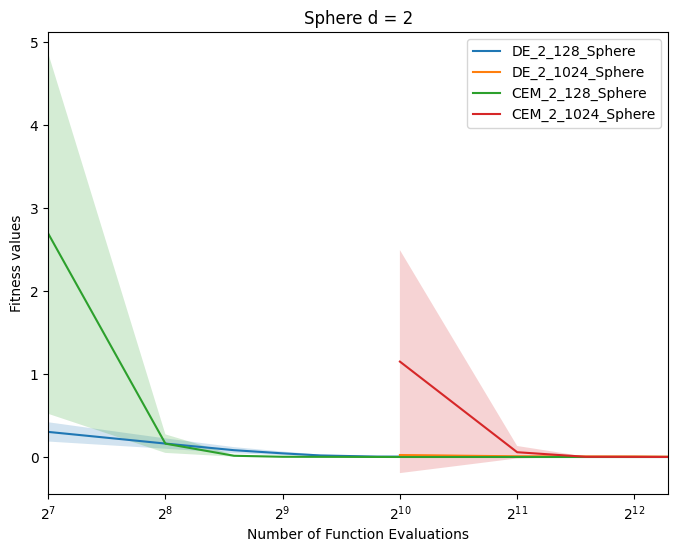

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_2_128_Sphere_count,de_2_128_Sphere_fitness,label="DE_2_128_Sphere");
ax.fill_between(de_2_128_Sphere_count, de_2_128_Sphere_lower, de_2_128_Sphere_upper, alpha=0.2)

ax.plot(de_2_1024_Sphere_count,de_2_1024_Sphere_fitness,label="DE_2_1024_Sphere");
ax.fill_between(de_2_1024_Sphere_count, de_2_1024_Sphere_lower, de_2_1024_Sphere_upper, alpha=0.2)

ax.plot(cem_2_128_Sphere_count,cem_2_128_Sphere_fitness,label="CEM_2_128_Sphere");
ax.fill_between(cem_2_128_Sphere_count, cem_2_128_Sphere_lower, cem_2_128_Sphere_upper, alpha=0.2)

ax.plot(cem_2_1024_Sphere_count,cem_2_1024_Sphere_fitness,label="CEM_2_1024_Sphere");
ax.fill_between(cem_2_1024_Sphere_count, cem_2_1024_Sphere_lower, cem_2_1024_Sphere_upper, alpha=0.2)

ax.set_xscale('log',base=2)
#ax.set_yscale('symlog', base=2)
ax.set_xlim(128,5000)
ax.set( title = 'Sphere d = 2', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

### Zakharov 

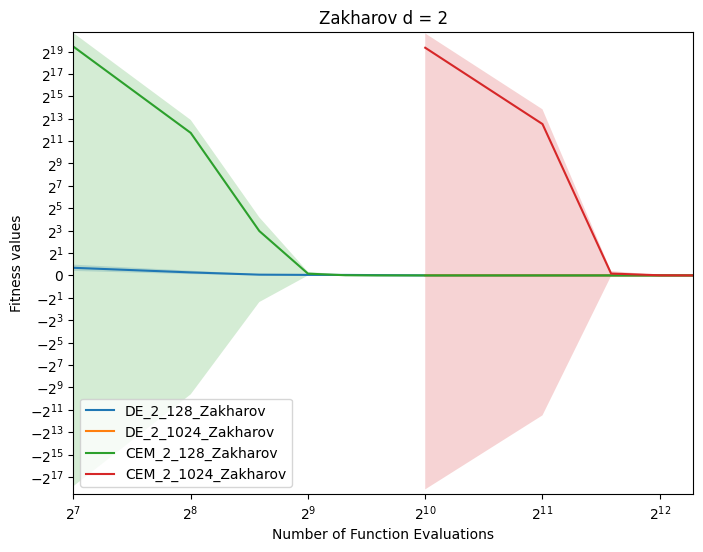

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_2_128_Zakharov_count,de_2_128_Zakharov_fitness,label="DE_2_128_Zakharov");
ax.fill_between(de_2_128_Zakharov_count, de_2_128_Zakharov_lower, de_2_128_Zakharov_upper, alpha=0.2)

ax.plot(de_2_1024_Zakharov_count,de_2_1024_Zakharov_fitness,label="DE_2_1024_Zakharov");
ax.fill_between(de_2_1024_Zakharov_count, de_2_1024_Zakharov_lower, de_2_1024_Zakharov_upper, alpha=0.2)

ax.plot(cem_2_128_Zakharov_count,cem_2_128_Zakharov_fitness,label="CEM_2_128_Zakharov");
ax.fill_between(cem_2_128_Zakharov_count, cem_2_128_Zakharov_lower, cem_2_128_Zakharov_upper, alpha=0.2)

ax.plot(cem_2_1024_Zakharov_count,cem_2_1024_Zakharov_fitness,label="CEM_2_1024_Zakharov");
ax.fill_between(cem_2_1024_Zakharov_count, cem_2_1024_Zakharov_lower, cem_2_1024_Zakharov_upper, alpha=0.2)

ax.set_xscale('log',base=2)
ax.set_yscale('symlog', base=2)
ax.set_xlim(128,5000)
ax.set( title = 'Zakharov d = 2', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

### Rosenbrock 

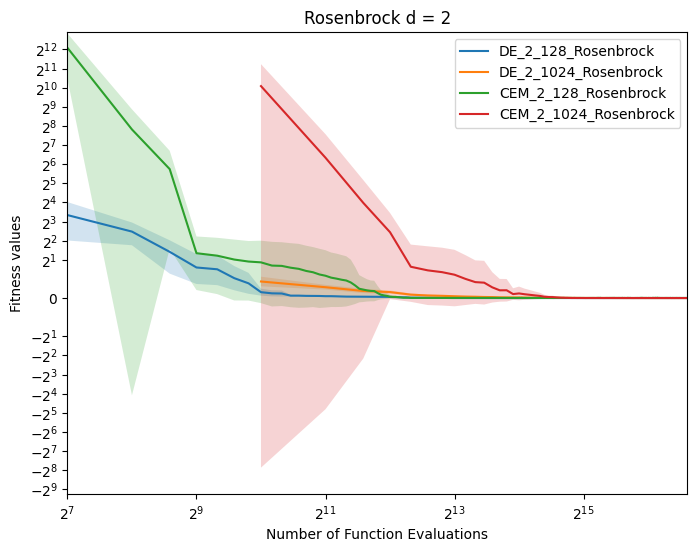

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_2_128_Rosenbrock_count,de_2_128_Rosenbrock_fitness,label="DE_2_128_Rosenbrock");
ax.fill_between(de_2_128_Rosenbrock_count, de_2_128_Rosenbrock_lower, de_2_128_Rosenbrock_upper, alpha=0.2)

ax.plot(de_2_1024_Rosenbrock_count,de_2_1024_Rosenbrock_fitness,label="DE_2_1024_Rosenbrock");
ax.fill_between(de_2_1024_Rosenbrock_count, de_2_1024_Rosenbrock_lower, de_2_1024_Rosenbrock_upper, alpha=0.2)

ax.plot(cem_2_128_Rosenbrock_count,cem_2_128_Rosenbrock_fitness,label="CEM_2_128_Rosenbrock");
ax.fill_between(cem_2_128_Rosenbrock_count, cem_2_128_Rosenbrock_lower, cem_2_128_Rosenbrock_upper, alpha=0.2)

ax.plot(cem_2_1024_Rosenbrock_count,cem_2_1024_Rosenbrock_fitness,label="CEM_2_1024_Rosenbrock");
ax.fill_between(cem_2_1024_Rosenbrock_count, cem_2_1024_Rosenbrock_lower, cem_2_1024_Rosenbrock_upper, alpha=0.2)

ax.set_xscale('log',base=2)
ax.set_yscale('symlog', base=2)
ax.set_xlim(128,100000)
ax.set( title = 'Rosenbrock d = 2', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

### Michalewicz

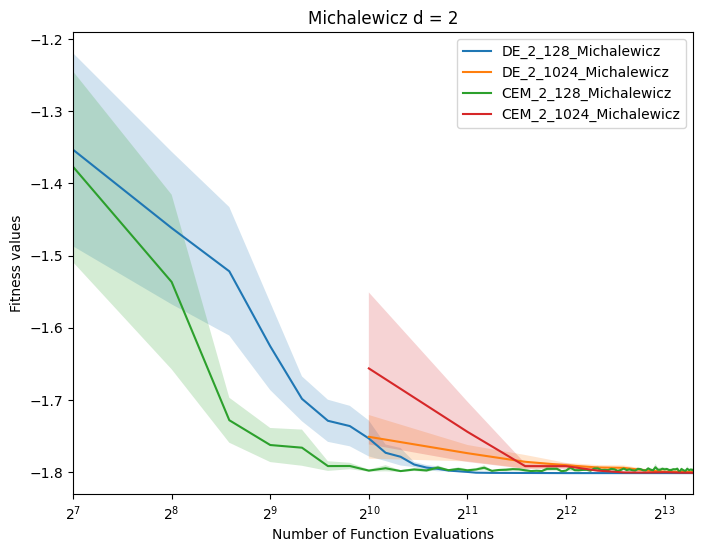

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_2_128_Michalewicz_count,de_2_128_Michalewicz_fitness,label="DE_2_128_Michalewicz");
ax.fill_between(de_2_128_Michalewicz_count, de_2_128_Michalewicz_lower, de_2_128_Michalewicz_upper, alpha=0.2)

ax.plot(de_2_1024_Michalewicz_count,de_2_1024_Michalewicz_fitness,label="DE_2_1024_Michalewicz");
ax.fill_between(de_2_1024_Michalewicz_count, de_2_1024_Michalewicz_lower, de_2_1024_Michalewicz_upper, alpha=0.2)

ax.plot(cem_2_128_Michalewicz_count,cem_2_128_Michalewicz_fitness,label="CEM_2_128_Michalewicz");
ax.fill_between(cem_2_128_Michalewicz_count, cem_2_128_Michalewicz_lower, cem_2_128_Michalewicz_upper, alpha=0.2)

ax.plot(cem_2_1024_Michalewicz_count,cem_2_1024_Michalewicz_fitness,label="CEM_2_1024_Michalewicz");
ax.fill_between(cem_2_1024_Michalewicz_count, cem_2_1024_Michalewicz_lower, cem_2_1024_Michalewicz_upper, alpha=0.2)

ax.set_xscale('log',base=2)
#ax.set_yscale('symlog', base=2)
ax.set_xlim(128,10000)
ax.set( title = 'Michalewicz d = 2', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

### Ackley

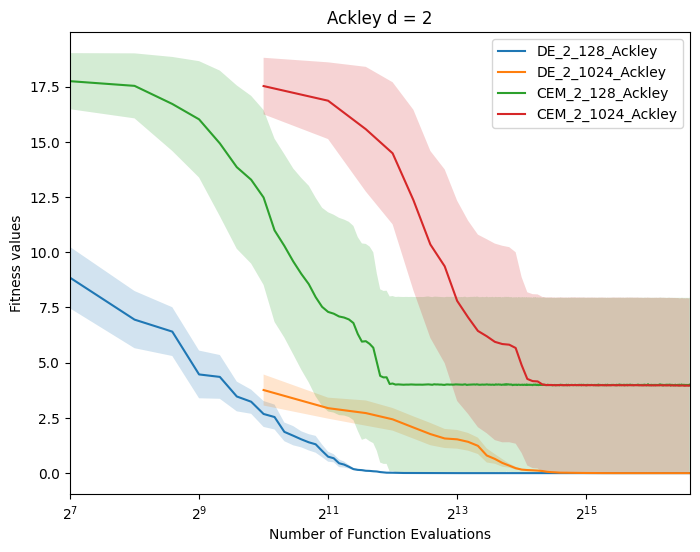

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_2_128_Ackley_count,de_2_128_Ackley_fitness,label="DE_2_128_Ackley");
ax.fill_between(de_2_128_Ackley_count, de_2_128_Ackley_lower, de_2_128_Ackley_upper, alpha=0.2)

ax.plot(de_2_1024_Ackley_count,de_2_1024_Ackley_fitness,label="DE_2_1024_Ackley");
ax.fill_between(de_2_1024_Ackley_count, de_2_1024_Ackley_lower, de_2_1024_Ackley_upper, alpha=0.2)

ax.plot(cem_2_128_Ackley_count,cem_2_128_Ackley_fitness,label="CEM_2_128_Ackley");
ax.fill_between(cem_2_128_Ackley_count, cem_2_128_Ackley_lower, cem_2_128_Ackley_upper, alpha=0.2)

ax.plot(cem_2_1024_Ackley_count,cem_2_1024_Ackley_fitness,label="CEM_2_1024_Ackley");
ax.fill_between(cem_2_1024_Ackley_count, cem_2_1024_Ackley_lower, cem_2_1024_Ackley_upper, alpha=0.2)

ax.set_xscale('log',base=2)
#ax.set_yscale('symlog', base=2)
ax.set_xlim(128,100000)
ax.set( title = 'Ackley d = 2', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

## d = 10

### Sphere 

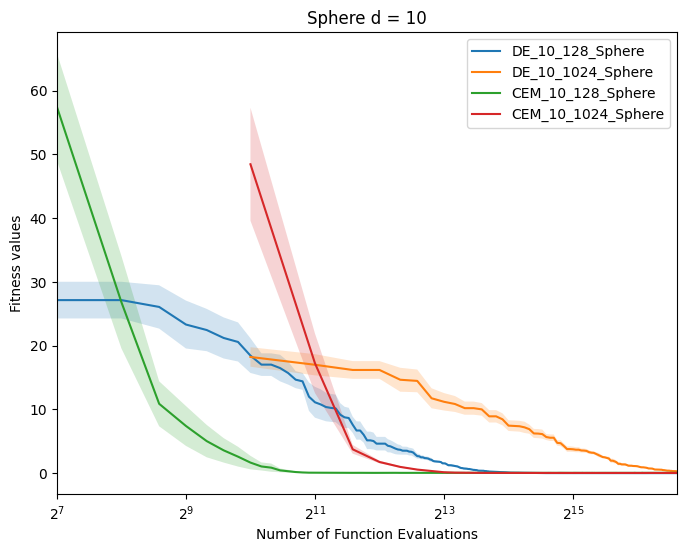

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_10_128_Sphere_count,de_10_128_Sphere_fitness,label="DE_10_128_Sphere");
ax.fill_between(de_10_128_Sphere_count, de_10_128_Sphere_lower, de_10_128_Sphere_upper, alpha=0.2)

ax.plot(de_10_1024_Sphere_count,de_10_1024_Sphere_fitness,label="DE_10_1024_Sphere");
ax.fill_between(de_10_1024_Sphere_count, de_10_1024_Sphere_lower, de_10_1024_Sphere_upper, alpha=0.2)

ax.plot(cem_10_128_Sphere_count,cem_10_128_Sphere_fitness,label="CEM_10_128_Sphere");
ax.fill_between(cem_10_128_Sphere_count, cem_10_128_Sphere_lower, cem_10_128_Sphere_upper, alpha=0.2)

ax.plot(cem_10_1024_Sphere_count,cem_10_1024_Sphere_fitness,label="CEM_10_1024_Sphere");
ax.fill_between(cem_10_1024_Sphere_count, cem_10_1024_Sphere_lower, cem_10_1024_Sphere_upper, alpha=0.2)

ax.set_xscale('log',base=2)
#ax.set_yscale('symlog', base=2)
ax.set_xlim(128,100000)
ax.set( title = 'Sphere d = 10', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

### Zakharov 

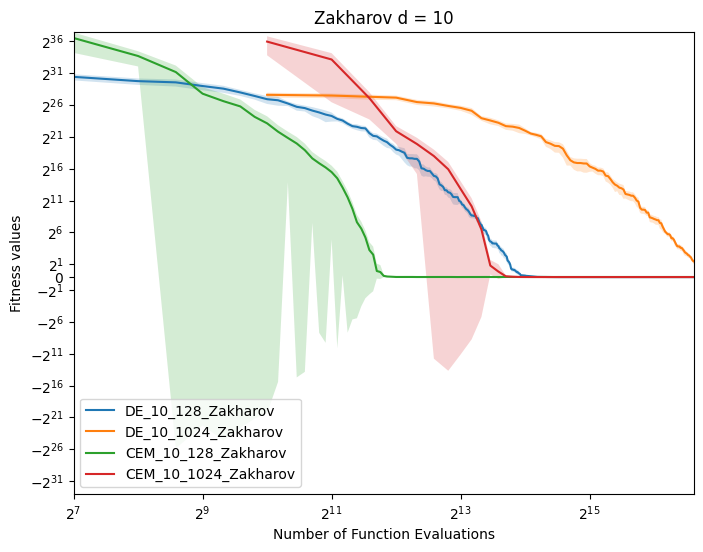

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_10_128_Zakharov_count,de_10_128_Zakharov_fitness,label="DE_10_128_Zakharov");
ax.fill_between(de_10_128_Zakharov_count, de_10_128_Zakharov_lower, de_10_128_Zakharov_upper, alpha=0.2)

ax.plot(de_10_1024_Zakharov_count,de_10_1024_Zakharov_fitness,label="DE_10_1024_Zakharov");
ax.fill_between(de_10_1024_Zakharov_count, de_10_1024_Zakharov_lower, de_10_1024_Zakharov_upper, alpha=0.2)

ax.plot(cem_10_128_Zakharov_count,cem_10_128_Zakharov_fitness,label="CEM_10_128_Zakharov");
ax.fill_between(cem_10_128_Zakharov_count, cem_10_128_Zakharov_lower, cem_10_128_Zakharov_upper, alpha=0.2)

ax.plot(cem_10_1024_Zakharov_count,cem_10_1024_Zakharov_fitness,label="CEM_10_1024_Zakharov");
ax.fill_between(cem_10_1024_Zakharov_count, cem_10_1024_Zakharov_lower, cem_10_1024_Zakharov_upper, alpha=0.2)

ax.set_xscale('log',base=2)
ax.set_yscale('symlog', base=2)
ax.set_xlim(128,100000)
ax.set( title = 'Zakharov d = 10', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

### Rosenbrock 

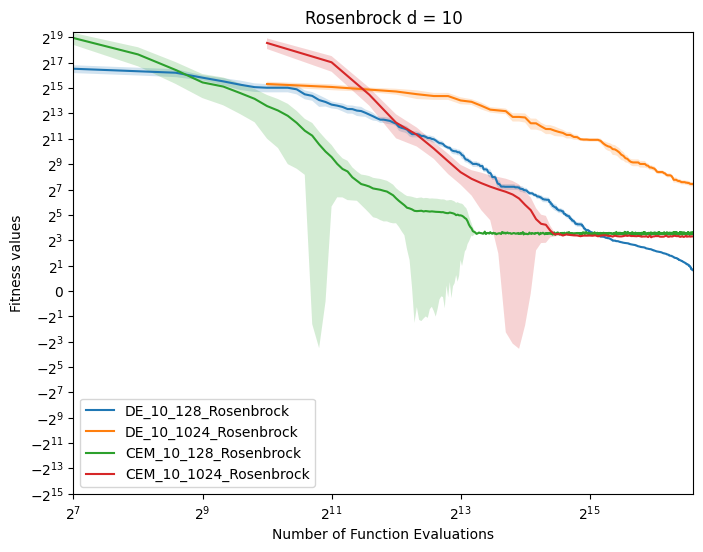

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_10_128_Rosenbrock_count,de_10_128_Rosenbrock_fitness,label="DE_10_128_Rosenbrock");
ax.fill_between(de_10_128_Rosenbrock_count, de_10_128_Rosenbrock_lower, de_10_128_Rosenbrock_upper, alpha=0.2)

ax.plot(de_10_1024_Rosenbrock_count,de_10_1024_Rosenbrock_fitness,label="DE_10_1024_Rosenbrock");
ax.fill_between(de_10_1024_Rosenbrock_count, de_10_1024_Rosenbrock_lower, de_10_1024_Rosenbrock_upper, alpha=0.2)

ax.plot(cem_10_128_Rosenbrock_count,cem_10_128_Rosenbrock_fitness,label="CEM_10_128_Rosenbrock");
ax.fill_between(cem_10_128_Rosenbrock_count, cem_10_128_Rosenbrock_lower, cem_10_128_Rosenbrock_upper, alpha=0.2)

ax.plot(cem_10_1024_Rosenbrock_count,cem_10_1024_Rosenbrock_fitness,label="CEM_10_1024_Rosenbrock");
ax.fill_between(cem_10_1024_Rosenbrock_count, cem_10_1024_Rosenbrock_lower, cem_10_1024_Rosenbrock_upper, alpha=0.2)

ax.set_xscale('log',base=2)
ax.set_yscale('symlog', base=2)
ax.set_xlim(128,100000)
ax.set( title = 'Rosenbrock d = 10', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

### Michalewicz

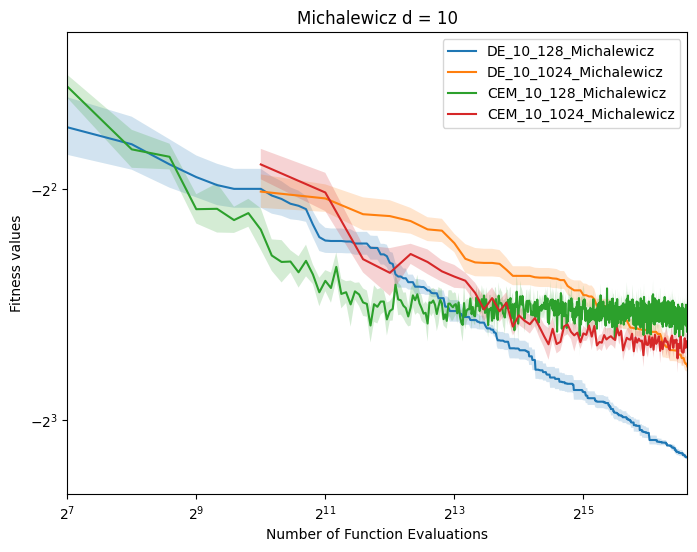

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_10_128_Michalewicz_count,de_10_128_Michalewicz_fitness,label="DE_10_128_Michalewicz");
ax.fill_between(de_10_128_Michalewicz_count, de_10_128_Michalewicz_lower, de_10_128_Michalewicz_upper, alpha=0.2)

ax.plot(de_10_1024_Michalewicz_count,de_10_1024_Michalewicz_fitness,label="DE_10_1024_Michalewicz");
ax.fill_between(de_10_1024_Michalewicz_count, de_10_1024_Michalewicz_lower, de_10_1024_Michalewicz_upper, alpha=0.2)

ax.plot(cem_10_128_Michalewicz_count,cem_10_128_Michalewicz_fitness,label="CEM_10_128_Michalewicz");
ax.fill_between(cem_10_128_Michalewicz_count, cem_10_128_Michalewicz_lower, cem_10_128_Michalewicz_upper, alpha=0.2)

ax.plot(cem_10_1024_Michalewicz_count,cem_10_1024_Michalewicz_fitness,label="CEM_10_1024_Michalewicz");
ax.fill_between(cem_10_1024_Michalewicz_count, cem_10_1024_Michalewicz_lower, cem_10_1024_Michalewicz_upper, alpha=0.2)

ax.set_xscale('log',base=2)
ax.set_yscale('symlog', base=2)
ax.set_xlim(128,100000)
ax.set( title = 'Michalewicz d = 10', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

### Ackley

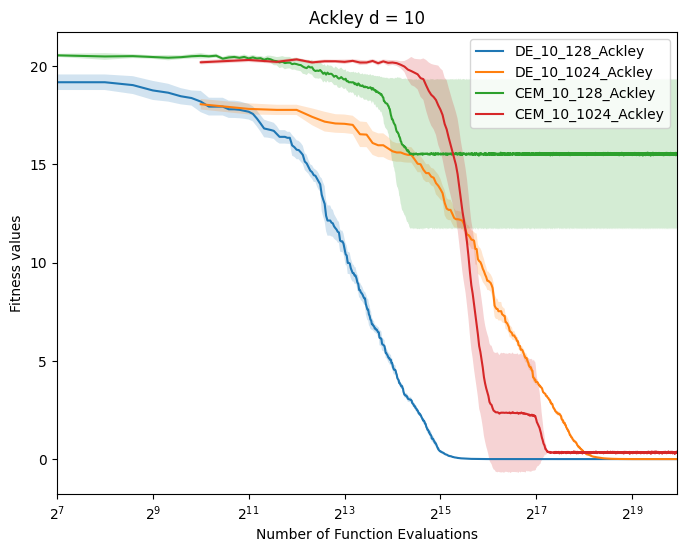

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(de_10_128_Ackley_count,de_10_128_Ackley_fitness,label="DE_10_128_Ackley");
ax.fill_between(de_10_128_Ackley_count, de_10_128_Ackley_lower, de_10_128_Ackley_upper, alpha=0.2)

ax.plot(de_10_1024_Ackley_count,de_10_1024_Ackley_fitness,label="DE_10_1024_Ackley");
ax.fill_between(de_10_1024_Ackley_count, de_10_1024_Ackley_lower, de_10_1024_Ackley_upper, alpha=0.2)

ax.plot(cem_10_128_Ackley_count,cem_10_128_Ackley_fitness,label="CEM_10_128_Ackley");
ax.fill_between(cem_10_128_Ackley_count, cem_10_128_Ackley_lower, cem_10_128_Ackley_upper, alpha=0.2)

ax.plot(cem_10_1024_Ackley_count,cem_10_1024_Ackley_fitness,label="CEM_10_1024_Ackley");
ax.fill_between(cem_10_1024_Ackley_count, cem_10_1024_Ackley_lower, cem_10_1024_Ackley_upper, alpha=0.2)

ax.set_xscale('log',base=2)
#ax.set_yscale('symlog', base=2)
ax.set_xlim(128,1000000)
ax.set( title = 'Ackley d = 10', xlabel= 'Number of Function Evaluations', ylabel= 'Fitness values')
ax.legend();

# Table

In [248]:
table_size=[32, 64, 128, 256, 512, 1024]

In [359]:
def load (activate, d, pop, f):
    temp = []
    mean = []
    std = []
    for i in range(10):
        mssv=20521493+i
        a=np.load('D:/UIT/3rd year/Sem 1/CS410/homework/Lab 3/'+ str(activate) +'_np/' + str(f) + '/' + str(pop) + '_' + str(d) + '_' + str(mssv) +'.npy',allow_pickle=True)
        temp.append(a[-1][-2])
    mean = np.mean(temp)
    std = np.std(temp)
    return mean, std

In [442]:
def loading(activate, d,f):
    mean = []
    std = []
    for idx in table_size:
        a, b = load(activate, d, idx, f)
        mean.append(a)
        std.append(b)
    # mean=np.array(mean)
    # std=np.array(std)
    mean=np.round(mean, decimals=6)
    std=np.round(std, decimals=6)
    return mean, std

In [436]:
def high_light(table):
  df = table.copy()
  df.loc[:,:] = 'background-color: gray'
  for i in range (len(p_value)):
    if (p_value[i] < 0.05):
      if (DE_mean[i] < CEM_mean[i]):
        df['DE'].iloc[i] = 'background-color: blue'
      else:
        df['CEM'].iloc[i] = 'background-color: blue'
  return df

In [437]:
def table():
    data = {'DE': DE_mean,'CEM': CEM_mean}
    df = pd.DataFrame(data,table_size)
    df['DE'] = df['DE'].astype(str) + '(' + DE_std.astype(str) + ')'
    df['CEM'] = df['CEM'].astype(str) + '(' + CEM_std.astype(str) + ')'
    df = df.style.apply(high_light, axis=None)
    return df

## d = 2

### Sphere 

In [438]:
DE_mean, DE_std = loading('DE',2,'Sphere')
CEM_mean, CEM_std = loading('CEM',2,'Sphere')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_2_Sphere = table()
df_2_Sphere

,DE,CEM
32,0.0(0.0),0.000487(0.000618)
64,0.0(0.0),0.000369(0.000363)
128,0.0(0.0),0.000256(0.000204)
256,0.0(0.0),7.1e-05(3.6e-05)
512,0.0(0.0),5.3e-05(4.5e-05)
1024,0.0(0.0),2.2e-05(2.7e-05)


### Zakharov

In [443]:
DE_mean, DE_std = loading('DE',2,'Zakharov')
CEM_mean, CEM_std = loading('CEM',2,'Zakharov')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_2_Zakharov = table()
df_2_Zakharov

,DE,CEM
32,0.0(0.0),1e-06(2e-06)
64,0.0(0.0),1e-06(2e-06)
128,0.0(0.0),0.0(0.0)
256,0.0(0.0),0.0(0.0)
512,0.0(0.0),0.0(0.0)
1024,0.0(0.0),0.0(0.0)


### Rosenbrock

In [444]:
DE_mean, DE_std = loading('DE',2,'Rosenbrock')
CEM_mean, CEM_std = loading('CEM',2,'Rosenbrock')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_2_Rosenbrock = table()
df_2_Rosenbrock

,DE,CEM
32,0.0(0.0),0.032943(0.042177)
64,0.0(0.0),0.011773(0.004874)
128,0.0(0.0),0.004661(0.004536)
256,0.0(0.0),0.00211(0.001405)
512,0.0(0.0),0.000972(0.000818)
1024,0.0(0.0),0.000547(0.000769)


### Michalewicz

In [446]:
DE_mean, DE_std = loading('DE',2,'Michalewicz')
CEM_mean, CEM_std = loading('CEM',2,'Michalewicz')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_2_Michalewicz = table()
df_2_Michalewicz

,DE,CEM
32,-1.801303(0.0),-1.787389(0.012718)
64,-1.801303(0.0),-1.788733(0.011222)
128,-1.801303(0.0),-1.792611(0.004828)
256,-1.801303(0.0),-1.799292(0.001707)
512,-1.801303(0.0),-1.799915(0.001244)
1024,-1.801303(0.0),-1.800638(0.000585)


### Ackley

In [447]:
DE_mean, DE_std = loading('DE',2,'Ackley')
CEM_mean, CEM_std = loading('CEM',2,'Ackley')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_2_Ackley = table()
df_2_Ackley

,DE,CEM
32,0.0(0.0),13.19812(8.63655)
64,0.0(0.0),4.211265(7.754116)
128,0.0(0.0),3.997782(7.895554)
256,0.0(0.0),1.994629(5.925614)
512,0.0(0.0),3.964577(7.893638)
1024,0.0(0.0),3.963469(7.901655)


## d = 10

### Sphere 

In [448]:
DE_mean, DE_std = loading('DE',10,'Sphere')
CEM_mean, CEM_std = loading('CEM',10,'Sphere')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_10_Sphere = table()
df_10_Sphere

,DE,CEM
32,0.0(0.0),0.07576(0.014055)
64,0.0(0.0),0.060168(0.018846)
128,0.0(0.0),0.042275(0.014217)
256,0.0(0.0),0.035037(0.010177)
512,0.0(0.0),0.029666(0.005958)
1024,0.0(0.0),0.025431(0.005798)


### Zakharov

In [449]:
DE_mean, DE_std = loading('DE',10,'Zakharov')
CEM_mean, CEM_std = loading('CEM',10,'Zakharov')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_10_Zakharov = table()
df_10_Zakharov

,DE,CEM
32,0.0(0.0),0.03415(0.021652)
64,0.0(0.0),0.022469(0.009865)
128,0.0(0.0),0.012361(0.00801)
256,0.0(0.0),0.009944(0.007882)
512,0.0(0.0),0.007154(0.002611)
1024,0.0(0.0),0.004788(0.002329)


### Rosenbrock

In [450]:
DE_mean, DE_std = loading('DE',10,'Rosenbrock')
CEM_mean, CEM_std = loading('CEM',10,'Rosenbrock')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_10_Rosenbrock = table()
df_10_Rosenbrock

,DE,CEM
32,0.0(0.0),13.874549(2.038791)
64,0.0(0.0),12.794836(1.290451)
128,0.0(0.0),12.005283(1.248712)
256,0.0(0.0),11.297475(0.889276)
512,0.00016(4e-05),10.683507(0.814169)
1024,0.392721(0.042772),9.679819(0.502252)


### Michalewicz

In [451]:
DE_mean, DE_std = loading('DE',10,'Michalewicz')
CEM_mean, CEM_std = loading('CEM',10,'Michalewicz')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_10_Michalewicz = table()
df_10_Michalewicz

,DE,CEM
32,-9.638353(0.020913),-5.042573(0.396696)
64,-9.655975(0.012529),-5.58716(0.589786)
128,-9.660152(0.0),-5.847377(0.476882)
256,-9.660152(0.0),-6.166208(0.582969)
512,-9.660151(2e-06),-6.239974(0.404856)
1024,-9.230582(0.054788),-6.461301(0.357392)


### Ackley

In [452]:
DE_mean, DE_std = loading('DE',10,'Ackley')
CEM_mean, CEM_std = loading('CEM',10,'Ackley')
t_test, p_value = ttest_ind_from_stats(DE_mean, DE_std,6,CEM_mean, CEM_std,6)
df_10_Ackley = table()
df_10_Ackley

,DE,CEM
32,0.0(0.0),19.74641(0.238034)
64,0.0(0.0),19.605211(0.47629)
128,0.0(0.0),15.504235(7.589588)
256,0.0(0.0),13.581434(8.626103)
512,0.0(0.0),2.165591(5.408601)
1024,0.0(0.0),0.334505(0.058339)


# Gif

In [317]:
def global_minimun(f):
    if f == Sphere or f == Zakharov or f == Ackley:
        return [0,0]
    if f == Rosenbrock:
        return [1,1]
    if f == Michalewicz:
        return [2.2, 1.57]

In [459]:
def gif(activate,f,name,iter=50):
    bounds=Bound(f)
    results, all_pops = activate(f, bounds*2, popsize=32, mssv=20521493)
    x = np.linspace(bounds[0][0], bounds[0][1], 100)
    y = np.linspace(bounds[0][0], bounds[0][1], 100)
    X, Y = np.meshgrid(x, y)
    Z = f([X,Y])
    minimum = global_minimun(f)
    fig = plt.figure(figsize=(6,6))
    camera = Camera(fig)
    plt.title(name)
    #for iteration in range(0,len(all_pops), 100):
    for iteration in range(iter):
        plt.contourf(X, Y, Z, 20, cmap='viridis', alpha=0.8)
        plt.axis('square')
        plt.scatter(results[iteration][0][0],results[iteration][0][1], s=100, c='#66B22E')
        plt.scatter(all_pops[iteration][:,0],all_pops[iteration][:,1], s=50, c='#FFB7C5')
        plt.scatter(minimum[0],minimum[1],c='#DC143C', marker='x')
        camera.snap()
    animation = camera.animate(repeat=True)
    animation.save(name+'.gif',writer="pillow")
    return

## Sphere


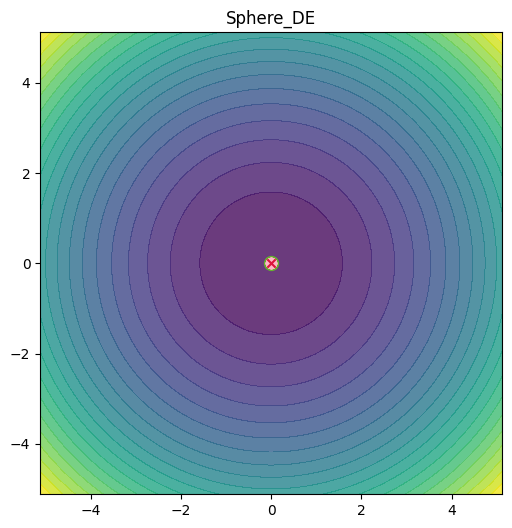

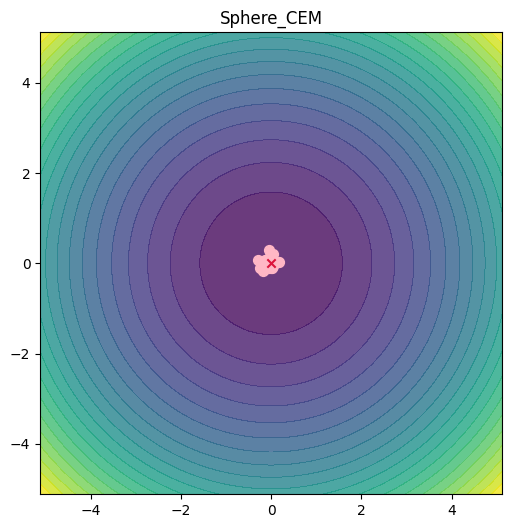

In [342]:
gif(de,Sphere,'Sphere_DE')
gif(cem,Sphere,'Sphere_CEM')

## Zakharov

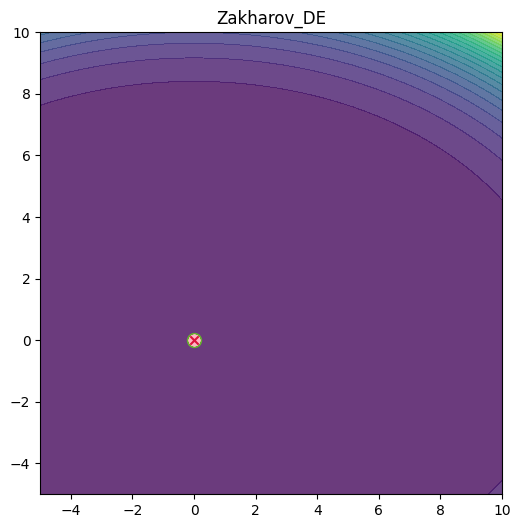

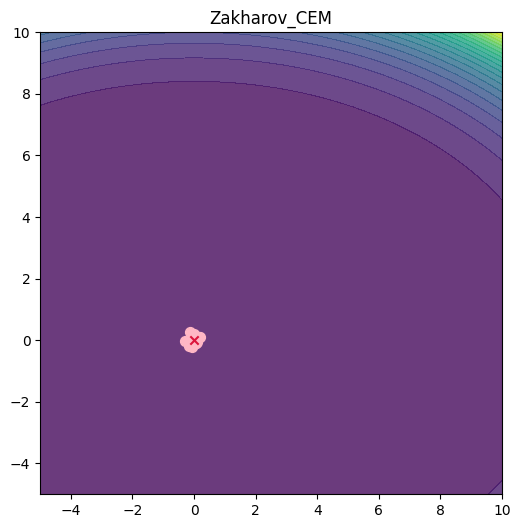

In [344]:
gif(de,Zakharov,'Zakharov_DE')
gif(cem,Zakharov,'Zakharov_CEM')

## Rosenbrock

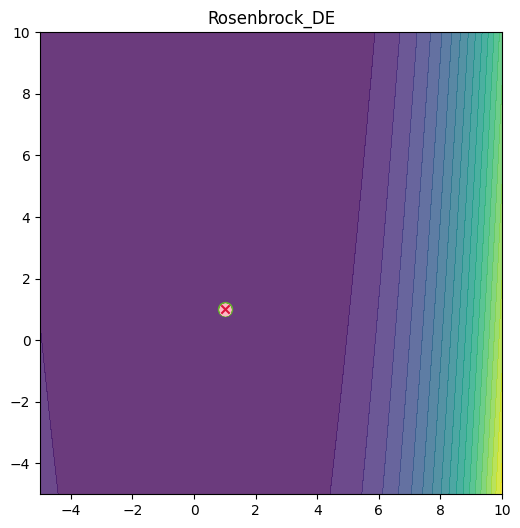

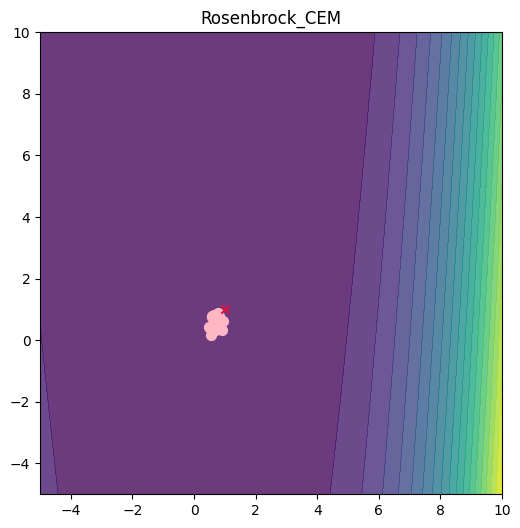

In [348]:
gif(de,Rosenbrock,'Rosenbrock_DE',iter=100)
gif(cem,Rosenbrock,'Rosenbrock_CEM',iter=500)

## Michalewicz

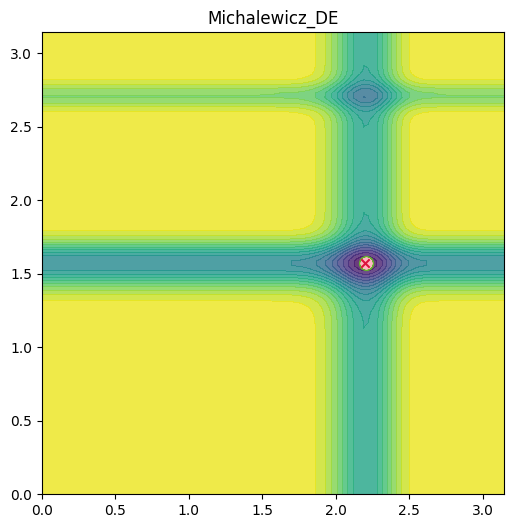

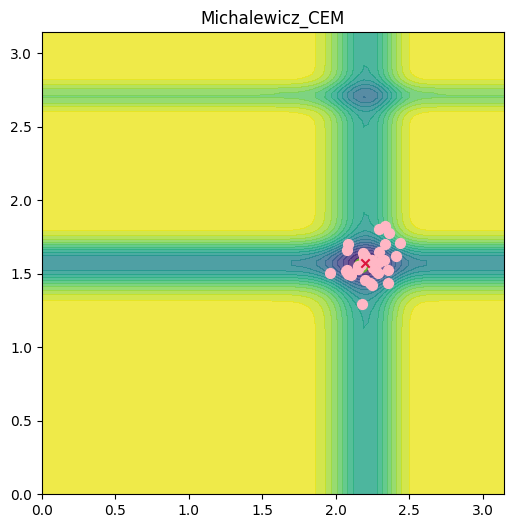

In [357]:
gif(de,Michalewicz,'Michalewicz_DE')
gif(cem,Michalewicz,'Michalewicz_CEM',iter=500)

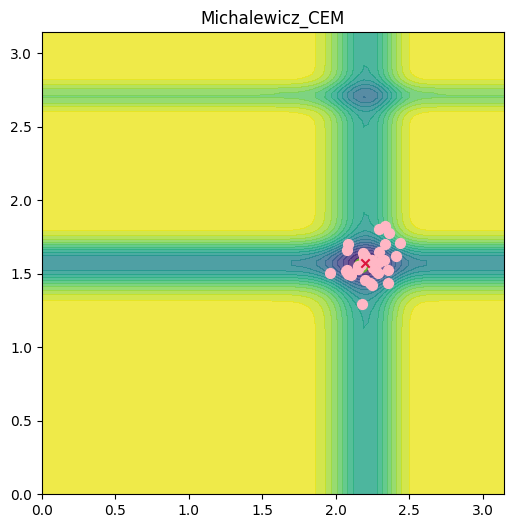

## Ackley

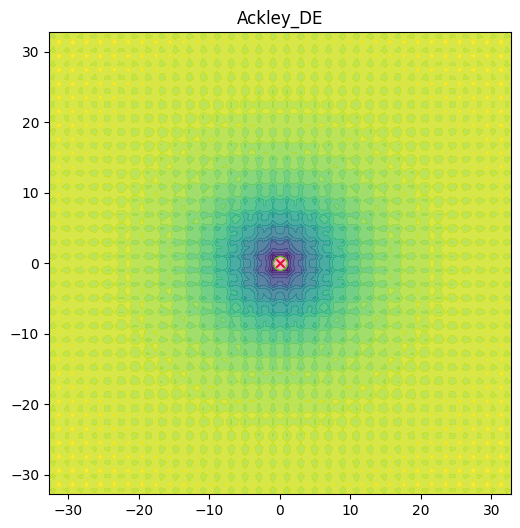

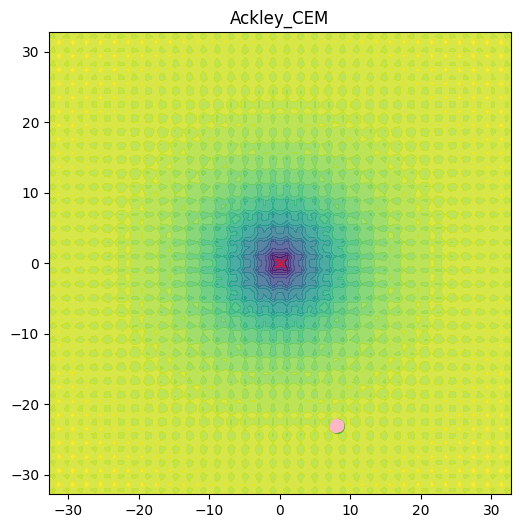

In [358]:
gif(de,Ackley,'Ackley_DE')
gif(cem,Ackley,'Ackley_CEM',iter=3125)